<a href="https://colab.research.google.com/github/jonzyyyy/AlphaLab/blob/OOP-fied/AlphaLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup & Libraries

### Setting up necessary keys and env variables
(only required to run at the start of execution)

In [1]:
!pip install python-dotenv --quiet

from google.colab import drive
drive.mount('/content/drive')

# Copy Alpha Lab notebook to folder
!cp "/content/drive/MyDrive/Colab Notebooks/AlphaLab.ipynb" AlphaLab/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cp: cannot create regular file 'AlphaLab/': Not a directory


In [2]:
!pip install yfinance --quiet
!pip install vectorbt --quiet
!pip install streamlit pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.8/527.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import vectorbt as vbt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pyngrok import ngrok
import os

This block of code below expects a secret that contains the necessary private API keys.

API Keys required:
1. NGROK

In [4]:
# !ngrok config add-authtoken NGROK_API_KEY
from google.colab import userdata
ngrok_token = userdata.get('NGROK_API_KEY')
ngrok.set_auth_token(ngrok_token)

In [5]:
# Parameters
SPLIT_RATIO = 0.7
DATA_YEARS = 2
TOP_N_STOCKS = 5
ticker = 'SPY' # Benchmark ticker
subset_tickers = 25

# --- Caching Configuration for S&P500 Data ---
DEBUG = True # Set to True to use cached data, False to fetch live data.
CACHE_FILE = 'sp500_market_caps.csv'

# 2. Download S&P 500 Stocks List
For simplicity, we'll fetch the tickers from Wikipedia

In [6]:
# --- Caching Logic ---
if DEBUG and os.path.exists(CACHE_FILE):
    print(f"DEBUG mode is ON. Loading data from cache file: {CACHE_FILE}")
    market_caps_df = pd.read_csv(CACHE_FILE)
else:
    print(f"Fetching live data. DEBUG is OFF or cache file not found.")
    # Get S&P 500 tickers from Wikipedia
    sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_table = pd.read_html(sp500_url)
    sp500 = sp500_table[0]
    # Correctly handle potential discrepancies in ticker symbols (e.g., 'BRK.B' vs 'BRK-B')
    tickers = sp500['Symbol'].str.replace('.', '-', regex=False).tolist()

    # We'll store market caps in a list of tuples
    market_caps = []

    print("Downloading market cap data for S&P 500 tickers...")
    for ticker in tickers:
        try:
            info = yf.Ticker(ticker).info
            cap = info.get('marketCap', None)
            if cap is not None:
                market_caps.append((ticker, cap))
        except Exception as e:
            # print(f"Could not fetch data for {ticker}: {e}")
            continue  # skip tickers with issues

    # Convert to DataFrame
    market_caps_df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])

    # Sort by market cap, descending
    market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False).reset_index(drop=True)

    # Save the fetched data to the cache file for future use
    market_caps_df.to_csv(CACHE_FILE, index=False)
    print(f"Live data saved to cache file: {CACHE_FILE}")

# --- Display the result ---
print("\nTop 5 S&P 500 companies by market cap:")
print(market_caps_df.head())

Fetching live data. DEBUG is OFF or cache file not found.
Live data saved to cache file: sp500_market_caps.csv

Top 5 S&P 500 companies by market cap:
  Ticker      MarketCap
0   NVDA  4204666290176
1   MSFT  3790967144448
2   AAPL  3154142035968
3   AMZN  2400686440448
4   GOOG  2250469015552


In [7]:
print(market_caps_df.head(5))  # Show top 5 largest S&P 500 stocks
# (Optional) Use a smaller subset for a fast demo
tickers = market_caps_df['Ticker'][:subset_tickers].tolist()
print(tickers)

  Ticker      MarketCap
0   NVDA  4204666290176
1   MSFT  3790967144448
2   AAPL  3154142035968
3   AMZN  2400686440448
4   GOOG  2250469015552
['NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOG', 'GOOGL', 'META', 'AVGO', 'TSLA', 'BRK-B', 'JPM', 'WMT', 'LLY', 'ORCL', 'V', 'NFLX', 'MA', 'XOM', 'COST', 'JNJ', 'PG', 'PLTR', 'HD', 'BAC', 'ABBV']


In [8]:
# =======================
# 3. Download Price Data
# =======================
end = datetime.today()
start = end - timedelta(days=365*DATA_YEARS)  # Last 2 years
price_data = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True, progress=False)
# print(price_data.head(3))

In [9]:
# =======================
# 4. Train-Test Split
# =======================
all_dates = price_data[tickers[0]]['Close'].index
split_idx = int(len(all_dates) * SPLIT_RATIO)
train_dates = all_dates[:split_idx]
test_dates = all_dates[split_idx:]
print(len(all_dates), len(test_dates))

# Helper function to get price for a given ticker and period
def get_close_prices(ticker, dates):
    try:
        close = price_data[ticker]['Close'].reindex(dates)
        return close
    except:
        return pd.Series(index=dates, dtype=float)

500 150


# Factor Based Algorithmic Equity Strategy

## Factor Used
1. Trailing P/E ratio - measures a company's current share price against its actual, historical earnings from the previous 12 months

    **Formula**: `Current Share Price / Trailing 12-Month EPS`

    **Limitation**: Past performance is not a guarantee of future results

2. The 6-Month Price Momentum factor is a strategy that aims to capitalize on existing market trends by identifying stocks that have performed well in the recent past

    **Formula**: `(Current Price / Price from 6 Months Ago) - 1`

    **Limitation**: A key risk is a momentum crash or reversal

## To consider
1. Forward P/E ratio - forward-looking metric that measures a company's current share price relative to its estimated future earnings per share (EPS)

    **Formula**: `Current Share Price / Forecasted 12-Month EPS`

    **Limitation**: Its primary weakness is that it's based on estimates, which can be inaccurate, overly optimistic, or change frequently.



In [10]:
import pandas as pd
import numpy as np
import yfinance as yf

class Factor:
    """Base class for financial factors."""
    def __init__(self, name):
        self.name = name

    def calculate(self, price_data_close, tickers):
        """
        Calculates the factor for the given tickers using point-in-time price data.
        Must be implemented by subclasses.
        """
        raise NotImplementedError("Subclass must implement abstract method")

    @staticmethod
    def calculate_factors(price_data_close, subset_tickers, factors):
        """
        Calculates specified factors for a subset of tickers using point-in-time data.

        Args:
            price_data_close (pd.DataFrame): DataFrame of 'Close' prices with tickers as columns.
            subset_tickers (list): List of tickers to calculate factors for.
            factors (list): List of Factor objects to calculate.

        Returns:
            pd.DataFrame: DataFrame with factors as columns and tickers as index.
        """
        factor_data = {}
        valid_tickers_with_data = [
            ticker for ticker in subset_tickers if ticker in price_data_close.columns and not price_data_close[ticker].dropna().empty
        ]
        # print(f"Calculating factors for {len(valid_tickers_with_data)} valid tickers...") # Debugging print

        for factor in factors:
            factor_values = []
            # print(f"  Calculating {factor.name}...") # Debugging print
            for ticker in valid_tickers_with_data:
                try:
                    # Pass relevant data to the factor's calculate method
                    value = factor.calculate(price_data_close[[ticker]].copy(), [ticker]) # Pass single ticker DataFrame
                    factor_values.append(value)
                except Exception as e:
                    # print(f"    Error calculating {factor.name} for {ticker}: {e}") # Debugging print
                    factor_values.append(np.nan) # Append NaN if calculation fails

            factor_data[factor.name] = factor_values

        factor_df = pd.DataFrame(factor_data, index=valid_tickers_with_data)
        factor_df = factor_df.dropna() # Drop tickers with NaN in any factor

        # print(f"Factor DataFrame after calculation and dropna:\n{factor_df.head()}") # Debugging print

        return factor_df


class Value(Factor):
    """Value factor based on Trailing P/E ratio."""
    def __init__(self):
        super().__init__('pe_ratio')

    def calculate(self, price_data_close, tickers):
        """
        Calculates the Trailing P/E ratio for a given ticker.

        Args:
            price_data_close (pd.DataFrame): DataFrame of 'Close' prices for a single ticker.
            tickers (list): A list containing the single ticker symbol.

        Returns:
            float: The Trailing P/E ratio or np.nan if unavailable.
        """
        if not tickers or not isinstance(tickers, list) or len(tickers) != 1:
            # print("Value factor requires a single ticker.") # Debugging print
            return np.nan
        ticker = tickers[0]
        try:
            info = yf.Ticker(ticker).info
            pe_ratio = info.get('trailingPE', np.nan)
            # print(f"  PE for {ticker}: {pe_ratio}") # Debugging print
            return pe_ratio
        except Exception as e:
            # print(f"  Error fetching PE for {ticker}: {e}") # Debugging print
            return np.nan


class Momentum(Factor):
    """Momentum factor based on 6-month price return."""
    def __init__(self):
        super().__init__('6m_return')

    def calculate(self, price_data_close, tickers):
        """
        Calculates the 6-month price return for a given ticker.

        Args:
            price_data_close (pd.DataFrame): DataFrame of 'Close' prices for a single ticker.
            tickers (list): A list containing the single ticker symbol.


        Returns:
            float: The 6-month return or np.nan if insufficient data.
        """
        if not tickers or not isinstance(tickers, list) or len(tickers) != 1:
            # print("Momentum factor requires a single ticker.") # Debugging print
            return np.nan
        ticker = tickers[0]
        try:
            # Ensure the price_data_close for the single ticker is a Series
            prices = price_data_close[ticker].dropna()
            # print(f"  Prices length for {ticker}: {len(prices)}") # Debugging print
            if len(prices) > 126: # Approximately 6 months of trading days
                return_6m = (prices.iloc[-1] / prices.iloc[-126]) - 1
                # print(f"  6m return for {ticker}: {return_6m}") # Debugging print
                return return_6m
            else:
                return np.nan
        except Exception as e:
            # print(f"  Error calculating 6m return for {ticker}: {e}") # Debugging print
            return np.nan

### Calculating Initial Factors

The static method `calculate_factors` from the `Factor` class is used to perform the initial factor calculations. The following parameters are passed to the method:
* The relevant price data, specifically the `price_data_close` DataFrame.
* The list of tickers being considered, stored in `subset_tickers`.
* A list of the factor objects that need to be calculated.

**Note on Point-in-Time Data:** This initial calculation uses all available price data. This is not strictly point-in-time accurate as it includes future data relative to the start of the backtest. However, this is done for an initial assessment, and the main backtesting loop later recalculates these factors correctly using only the data available at each specific rebalance point. This step assumes the `price_data_close` and `subset_tickers` variables have been defined previously.

In [11]:
# =======================
# 5. Factor Calculation (Value, Momentum) - Refactored
# =======================

# Filter subset_tickers based on available data in price_data
available_tickers = [ticker for ticker in tickers if ticker in price_data.columns.get_level_values(0)]
missing_tickers = [ticker for ticker in tickers if ticker not in price_data.columns.get_level_values(0)]

if missing_tickers:
    print(f"Warning: Data not available for the following tickers in price_data: {missing_tickers}. Skipping these for factor calculation.")

subset_tickers_filtered = available_tickers
print(f"Filtered subset_tickers: {subset_tickers_filtered}")


# Instantiate the factor classes
value_factor = Value()
momentum_factor = Momentum()

# Create a list of factors to use
factors_to_calculate = [value_factor, momentum_factor]

# Need to make sure price_data_close is aligned with subset_tickers and only contains Close prices
# We can reuse the logic from the backtesting cell for preparing price_data_close
# Note: This part still assumes 'price_data' is available and has the MultiIndex structure from yf.download
if isinstance(price_data.columns, pd.MultiIndex):
     # Select 'Close' for all tickers in subset_tickers_filtered
     price_data_close_all = price_data.loc[:, (subset_tickers_filtered, 'Close')]
     # Drop the 'Price' level to have tickers as single-level columns
     price_data_close_all.columns = price_data_close_all.columns.droplevel('Price')
else: # Handle case where price_data might not have a MultiIndex (e.g., single ticker download)
     # Assuming it's already the close series for a single ticker, convert to DataFrame
     price_data_close_all = pd.DataFrame(price_data)
     # Assuming subset_tickers_filtered has only one ticker in this case
     # This case might need adjustment if subset_tickers_filtered has multiple items but price_data is not MultiIndex
     if len(subset_tickers_filtered) == 1:
         price_data_close_all.columns = [subset_tickers_filtered[0]]
     else:
         # Handle error or unexpected structure
         print("Warning: price_data is not MultiIndex but subset_tickers_filtered has multiple items.")
         # Attempt to select assuming columns are already tickers
         price_data_close_all = price_data[subset_tickers_filtered]


# Now use the refactored calculate_factors method
factor_df = Factor.calculate_factors(price_data_close_all, subset_tickers_filtered, factors_to_calculate)

# The rest of the composite scoring and selection logic remains the same
print(factor_df.head(20))

Filtered subset_tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'GOOG', 'GOOGL', 'META', 'AVGO', 'TSLA', 'BRK-B', 'JPM', 'WMT', 'LLY', 'ORCL', 'V', 'NFLX', 'MA', 'XOM', 'COST', 'JNJ', 'PG', 'PLTR', 'HD', 'BAC', 'ABBV']
         pe_ratio  6m_return
NVDA    55.616130   0.290992
MSFT    39.355710   0.205923
AAPL    32.894080  -0.072595
AMZN    36.769108   0.024789
GOOG    20.752232  -0.041327
GOOGL   20.654018  -0.038425
META    27.543217   0.154014
AVGO   103.032720   0.241734
TSLA   188.371430  -0.203398
BRK-B   12.627932   0.023746
JPM     14.944587   0.158123
WMT     40.619660   0.046456
LLY     62.894050   0.022472
ORCL    56.555298   0.547293
V       35.080402   0.103918
NFLX    51.544758   0.435521
MA      38.755960   0.059536
XOM     14.293103  -0.014234
COST    54.061966   0.036413
JNJ     17.508020   0.126243


In [12]:
class StockSelector:
    """Handles composite scoring and stock selection based on factor data."""

    def __init__(self, factor_df, num_stocks_to_select):
        """
        Initializes the StockSelector.

        Args:
            factor_df (pd.DataFrame): DataFrame with factors as columns and tickers as index.
            num_stocks_to_select (int): The number of top stocks to select.
        """
        self.factor_df = factor_df.copy() # Work on a copy to avoid modifying the original
        self.num_stocks_to_select = num_stocks_to_select
        self.selected_tickers = []

    def perform_selection(self):
        """
        Performs composite scoring and selects the top N stocks.

        Returns:
            list: A list of selected ticker symbols.
        """
        if self.factor_df.empty:
            print("Factor DataFrame is empty. Cannot perform selection.")
            return []

        # Ensure 'pe_ratio' and '6m_return' columns exist before ranking
        if 'pe_ratio' in self.factor_df.columns and '6m_return' in self.factor_df.columns:
            # Rank: lower P/E is better, higher momentum is better
            # Handle NaNs in ranking by pushing them to the bottom (worst rank)
            self.factor_df['pe_rank'] = self.factor_df['pe_ratio'].rank(ascending=True, na_option='bottom')
            self.factor_df['mom_rank'] = self.factor_df['6m_return'].rank(ascending=False, na_option='bottom')

            # Simple equal-weight composite score
            # Fill NaNs in ranks with a value larger than any possible rank to ensure they get the worst composite score
            max_rank = self.factor_df.shape[0]
            self.factor_df['composite_score'] = (self.factor_df['pe_rank'].fillna(max_rank + 1) + self.factor_df['mom_rank'].fillna(max_rank + 1)) / 2

            # Select top N stocks
            # Ensure there are enough stocks to select num_stocks_to_select
            if not self.factor_df.empty and self.factor_df.shape[0] >= self.num_stocks_to_select:
                 selected = self.factor_df.nsmallest(self.num_stocks_to_select, 'composite_score')
                 self.selected_tickers = selected.index.tolist()
                 print(f"Selected top {self.num_stocks_to_select} stocks: {self.selected_tickers}")
            elif not self.factor_df.empty:
                 # If fewer than num_stocks_to_select are available, select all available
                 self.selected_tickers = self.factor_df.nsmallest(self.factor_df.shape[0], 'composite_score').index.tolist()
                 print(f"Selected {len(self.selected_tickers)} stocks (fewer than requested {self.num_stocks_to_select}): {self.selected_tickers}")
            else:
                print("No stocks available for selection after scoring.")
                self.selected_tickers = []
        else:
            print("Required factor columns ('pe_ratio', '6m_return') not found in factor_df for scoring.")
            self.selected_tickers = []

        return self.selected_tickers

In [13]:
# =======================
# 6. Composite Scoring & Stock Selection
# =======================

# Instantiate the StockSelector class
stock_selector = StockSelector(factor_df, TOP_N_STOCKS)

# Use the perform_selection method to get the selected tickers
selected_tickers = stock_selector.perform_selection()

# Print the initial selected tickers
print("\nInitial selected stocks based on all data:", selected_tickers)

Selected top 5 stocks: ['JPM', 'JNJ', 'BAC', 'META', 'BRK-B']

Initial selected stocks based on all data: ['JPM', 'JNJ', 'BAC', 'META', 'BRK-B']


In [14]:
# # =======================
# # 6. Composite Scoring & Stock Selection
# # =======================
# # Rank: lower P/E is better, higher momentum is better
# factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending
#                                                   =True)
# factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False)
# # Simple equal-weight composite score
# factor_df['composite_score'] = (factor_df['pe_rank'] + factor_df['mom_rank']) / 2

# # Select top N stocks
# selected = factor_df.nsmallest(TOP_N_STOCKS, 'composite_score')
# selected_tickers = selected.index.tolist()
# print("Selected stocks for backtest:", selected_tickers)

In [15]:
# # =======================
# # 7. Backtesting (Quarterly Rebalancing)
# # =======================

# # Filter price data for selected tickers and train/test periods
# selected_prices_train = price_data[selected_tickers].reindex(train_dates)
# selected_prices_test = price_data[selected_tickers].reindex(test_dates)
# print(len(test_dates))

# # 1. Find all trading days in your price data
# all_dates = selected_prices_test.index

# # 2. Set target rebalance dates (e.g., quarterly)
# rebalance_targets = pd.date_range(start=all_dates[0], end=all_dates[-1], freq='QS')

# # 3. Map each target rebalance date to the nearest available trading day ON OR AFTER the target
# mapped_rebalance_dates = []
# for target in rebalance_targets:
#     candidates = all_dates[all_dates >= target]
#     if not candidates.empty:
#         mapped_rebalance_dates.append(candidates[0])
# # Always include the very first day if it's not already in the list
# if all_dates[0] not in mapped_rebalance_dates:
#     mapped_rebalance_dates = [all_dates[0]] + mapped_rebalance_dates

# print("Final mapped rebalance dates:", mapped_rebalance_dates)

# # 4. Assign weights on these mapped rebalance dates
# portfolio = pd.DataFrame(1 / len(selected_prices_test.columns), index=all_dates, columns=selected_prices_test.columns)
# # print(portfolio.head(20))

# # 5. Returns and cumulative returns
# returns = selected_prices_test.pct_change().fillna(0)

# # Recalculate portfolio returns by applying weights only to 'Close' returns
# # Select only the 'Close' returns for the selected tickers
# close_returns_only = returns.loc[:, (selected_tickers, 'Close')]

# # Select only the 'Close' weights for the selected tickers
# portfolio_close_weights = portfolio.loc[:, (selected_tickers, 'Close')]

# # Calculate portfolio returns by multiplying close returns with close weights and summing across tickers
# portfolio_returns = (close_returns_only * portfolio_close_weights).sum(axis=1)

# # Multiply consecutive cumulative returns (+1 to get entire portfolio value)
# cum_returns = (1 + portfolio_returns_corrected).cumprod()

# print(portfolio_returns.head())

# Rebalancing and Backtesting strategy
Based on your code, here is a high-level explanation of how the rebalancing and backtesting strategy works. This process is designed to realistically simulate how an active investment strategy would be managed over time.

### **High-Level Strategy Explanation**

The strategy operates like a dynamic fund manager who periodically re-evaluates the market and adjusts their portfolio. It does this by looping through time in quarterly intervals and making investment decisions based **only on the information available at each point in time**.

Here is the step-by-step process:

1.  **Preparation**: The backtest first defines a "test period" (e.g., the last 30% of your historical data) and identifies the start date of each quarter within that period. These dates become the scheduled "rebalancing days."

2.  **The Simulation Loop**: The code then simulates the passing of time by looping through each rebalancing day. At each of these dates, it performs the following actions:
    * **Point-in-Time Analysis**: It looks backward, using only the historical data available up to that specific day to re-calculate the Value and Momentum factors for all stocks.
    * **Portfolio Re-Selection**: Based on these fresh, point-in-time factor scores, it re-ranks the stocks and selects the new "Top N" stocks to form the portfolio for the upcoming quarter.
    * **Holding Period**: The strategy then "holds" this newly selected portfolio until the next rebalancing day, recording its daily performance during this period.

3.  **Performance Calculation**: After the loop has run through all the quarters, the daily returns from each individual holding period are "stitched" together into one continuous performance history for the entire strategy.

4.  **Final Analysis**: This complete and stitched-together series of returns is used to calculate the final cumulative return and overall performance metrics like Annualized Return, Volatility, and the Sharpe Ratio.

This point-in-time rebalancing approach is a robust method because it avoids **lookahead bias**, ensuring that investment decisions are never made using information that would not have been available at the time.

## Future implementations

Metrics
1. Add Maximum Drawdown
2. Add Volatility

Additional points
1. Accounting for transaction fees


Starting point-in-time backtest with 4 rebalance periods...

Rebalancing for period starting 2024-12-10...
Analysing point in time data from 2023-07-21 to 2024-12-10
Selected top 5 stocks: ['JPM', 'BAC', 'HD', 'BRK-B', 'META']
  -> New portfolio selected for period starting 2024-12-10: ['JPM', 'BAC', 'HD', 'BRK-B', 'META']

Rebalancing for period starting 2025-01-01...
Analysing point in time data from 2023-07-21 to 2024-12-31
Selected top 5 stocks: ['JPM', 'BRK-B', 'HD', 'V', 'BAC']
  -> New portfolio selected for period starting 2025-01-01: ['JPM', 'BRK-B', 'HD', 'V', 'BAC']

Rebalancing for period starting 2025-04-01...
Analysing point in time data from 2023-07-21 to 2025-04-01
Selected top 5 stocks: ['BRK-B', 'JPM', 'BAC', 'XOM', 'V']
  -> New portfolio selected for period starting 2025-04-01: ['BRK-B', 'JPM', 'BAC', 'XOM', 'V']

Rebalancing for period starting 2025-07-01...
Analysing point in time data from 2023-07-21 to 2025-07-01
Selected top 5 stocks: ['JPM', 'BAC', 'META', 'BR

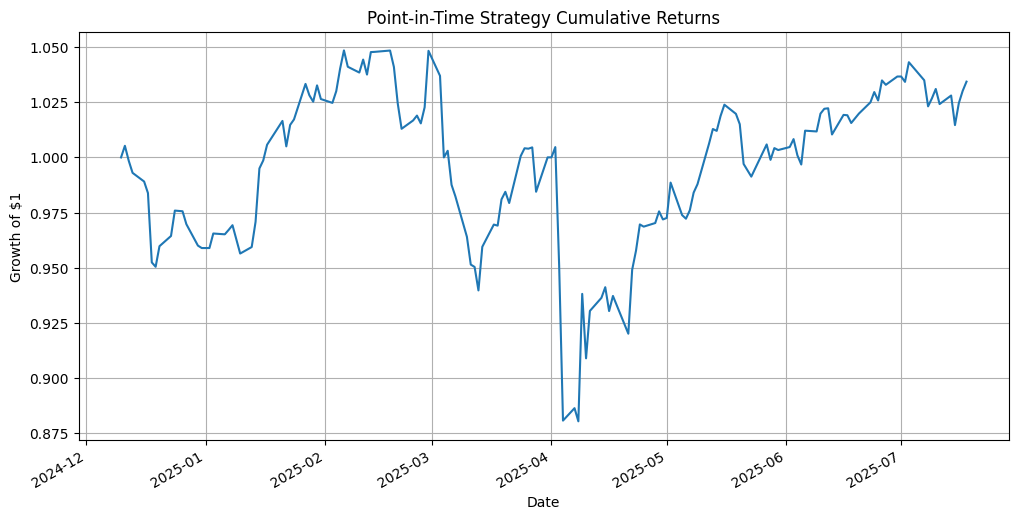


Total Return (Test): 3.43%
Annualized Return (Test): 5.83%
Annualized Volatility (Test): 21.89%
Sharpe Ratio (Test): 0.27


In [16]:
# =============================================================
# 7. Backtesting with Point-in-Time Quarterly Rebalancing
# =============================================================
price_data_close = price_data_close_all

# 2. Find the quarterly rebalance dates within the test period
# Use the index of the full price_data_close (all tickers) for the test period dates
all_dates = price_data_close.index
split_idx = int(len(all_dates) * SPLIT_RATIO)
test_dates = all_dates[split_idx:]

test_start_date, test_end_date = test_dates[0], test_dates[-1]
rebalance_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QS')

# Ensure the first day of the test period is included if it's not a quarter start
if test_start_date not in rebalance_dates:
    rebalance_dates = rebalance_dates.insert(0, test_start_date)

# 3. Loop through rebalance dates to simulate the strategy
all_period_returns = []
last_rebalance_date = None

print(f"Starting point-in-time backtest with {len(rebalance_dates)} rebalance periods...")

# Initialize last_selected_tickers before the loop
last_selected_tickers = [] # Will store the tickers selected in the previous rebalance period


for i, rebalance_date in enumerate(rebalance_dates):
    if last_rebalance_date is not None and last_selected_tickers:
        # Define the holding period for the previously selected portfolio
        # From the last rebalance date up to the day before the current one
        # Ensure the holding period does not extend beyond the test_end_date
        holding_period_mask = (price_data_close.index >= last_rebalance_date) & (price_data_close.index < rebalance_date)
        # Filter price_data_close for the holding period
        holding_period_prices = price_data_close.loc[holding_period_mask]

        if not holding_period_prices.empty:
            # Calculate returns for the selected tickers during this holding period
            # Ensure we only calculate returns for tickers that were actually in the last selected list
            # And that these tickers are present in the holding_period_prices columns
            valid_tickers_in_holding_period = [t for t in last_selected_tickers if t in holding_period_prices.columns]

            if valid_tickers_in_holding_period:
                period_prices_selected = holding_period_prices[valid_tickers_in_holding_period]
                period_returns = period_prices_selected.pct_change().fillna(0)
                # Assume equal weight for the period
                equal_weight_returns = period_returns.mean(axis=1)
                all_period_returns.append(equal_weight_returns)
            else:
                 print(f"  -> No valid selected tickers found in price data for holding period starting {last_rebalance_date.date()}.")


    # --- Point-in-Time Analysis for the current rebalance_date ---
    # Use only data available up to this point to decide the new portfolio
    print(f"\nRebalancing for period starting {rebalance_date.date()}...")
    # Ensure point_in_time_data includes the rebalance_date for factor calculation
    # The data should go up to and including the rebalance_date
    point_in_time_data = price_data_close[price_data_close.index <= rebalance_date]

    if point_in_time_data.empty:
        print("  -> Skipping: Not enough historical data to calculate factors.")
        last_selected_tickers = [] # Reset tickers as we can't select
        last_rebalance_date = rebalance_date # Still update the last rebalance date
        continue

    # Fix: Access the first and last index values, not columns
    print(f"Analysing point in time data from {point_in_time_data.index[0].date()} to {point_in_time_data.index[-1].date()}")

    # Recalculate factors using only point-in-time data using the refactored classes
    # Instantiate factor objects
    value_factor = Value()
    momentum_factor = Momentum()
    factors_to_calculate = [value_factor, momentum_factor]

    # Use the calculate_factors static method from the Factor class
    # Pass the relevant tickers for factor calculation (e.g., the initial subset or all S&P500)
    # 'tickers' is the list of tickers you are considering for selection (subset_tickers).
    # Pass the point_in_time_data which contains the Close prices for these tickers up to the rebalance date.
    factor_df_point_in_time = Factor.calculate_factors(point_in_time_data, tickers, factors_to_calculate) # Use 'tickers' (subset_tickers)


    if factor_df_point_in_time.empty:
        print("  -> Skipping: No valid tickers after factor calculation.")
        last_selected_tickers = [] # Reset tickers
        last_rebalance_date = rebalance_date # Still update the last rebalance date
        continue

    # --- Use the StockSelector class for point-in-time selection ---
    stock_selector_point_in_time = StockSelector(factor_df_point_in_time, TOP_N_STOCKS)
    # The perform_selection method returns the list of selected tickers
    current_period_selected_tickers = stock_selector_point_in_time.perform_selection()

    if not current_period_selected_tickers:
         print(f"  -> No stocks selected for period starting {rebalance_date.date()}.")
         last_selected_tickers = [] # No stocks selected for this period
    else:
        print(f"  -> New portfolio selected for period starting {rebalance_date.date()}: {current_period_selected_tickers}")
        # Update last_selected_tickers for the next holding period calculation
        last_selected_tickers = current_period_selected_tickers


    # Update the last rebalance date to the current one for the next iteration's holding period calculation
    last_rebalance_date = rebalance_date

# After the loop, process the returns from the last holding period
# The loop stops before calculating the returns for the period after the last rebalance date.
# We need to add the returns from the period between the last rebalance date and the test_end_date.
if last_rebalance_date is not None and last_selected_tickers:
    # Define the final holding period from the last rebalance date up to the test_end_date (inclusive)
    final_holding_period_mask = (price_data_close.index >= last_rebalance_date) & (price_data_close.index <= test_end_date)
    final_holding_period_prices = price_data_close.loc[final_holding_period_mask]

    if not final_holding_period_prices.empty:
        valid_tickers_in_final_period = [t for t in last_selected_tickers if t in final_holding_period_prices.columns]

        if valid_tickers_in_final_period:
            final_period_prices_selected = final_holding_period_prices[valid_tickers_in_final_period]
            final_period_returns = final_period_prices_selected.pct_change().fillna(0)
            final_equal_weight_returns = final_period_returns.mean(axis=1)
            all_period_returns.append(final_equal_weight_returns)
        else:
            print(f"\n  -> No valid selected tickers found in price data for final holding period starting {last_rebalance_date.date()}.")
    else:
        print("\n  -> No data for the final holding period.")



# 4. Concatenate all period returns into a single time series
if all_period_returns:
    # Concatenate returns, ensuring correct chronological order if they were added out of order (though the loop should prevent this)
    # Sort by index just in case
    portfolio_returns = pd.concat(all_period_returns).sort_index()

    # Drop any potential duplicates in the index that might occur at the boundary of holding periods
    portfolio_returns = portfolio_returns[~portfolio_returns.index.duplicated(keep='first')]

    # 5. Calculate final cumulative returns and performance stats
    # Correct calculation of cumulative returns: (1 + daily_returns).cumprod()
    # Ensure the first return is based on the initial value (which is 1 for growth of $1)
    cum_returns = (1 + portfolio_returns).cumprod()

    # Prepend a starting value of 1 at the very beginning of the test period
    # Find the actual start date of the returns series
    actual_start_date = portfolio_returns.index[0] if not portfolio_returns.empty else test_dates[0]
    start_value_series = pd.Series([1.0], index=[actual_start_date - pd.Timedelta(days=1)]) # Use day before for alignment
    cum_returns = pd.concat([start_value_series, cum_returns])

    # Reindex to the full test_dates to include days with no trades (returns are 0)
    # This assumes the price_data_close index is the true market index for the test period
    cum_returns = cum_returns.reindex(test_dates)
    # Forward fill the cumulative returns for days with no returns (weekends, holidays)
    cum_returns = cum_returns.ffill()


    print("\n--- Backtest Complete ---")
    # Displaying the final cumulative return plot
    plt.figure(figsize=(12, 6))
    # Ensure plot data does not contain NaNs at the beginning if start_value_series was used
    cum_returns.dropna().plot()
    plt.title('Point-in-Time Strategy Cumulative Returns')
    plt.ylabel('Growth of $1')
    plt.grid()
    plt.show()

    # Displaying the performance stats
    # Ensure metrics are calculated on the non-NaN parts of the cumulative returns series
    if not cum_returns.dropna().empty and len(cum_returns.dropna()) > 1:
        total_return = cum_returns.dropna().iloc[-1] - 1
        # Calculate duration based on the actual number of trading days in the portfolio_returns series
        duration_trading_days = len(portfolio_returns)
        # If there are actual trading days, calculate annualization factor
        annualization_factor = 252 / duration_trading_days if duration_trading_days > 0 else 0

        if annualization_factor > 0:
             # Calculate annualized return using the correct formula
             annualized_return = (1 + total_return)**annualization_factor - 1
             annualized_vol = portfolio_returns.std() * np.sqrt(252) # Volatility is based on daily returns
             sharpe = annualized_return / annualized_vol if annualized_vol != 0 else 0
        else:
             # Handle case with no trading days in returns
             annualized_return = 0
             annualized_vol = 0
             sharpe = 0
             print("\nNot enough trading days in the backtest period to calculate annualized metrics.")
             print(f"\nTotal Return (Test): {total_return:.2%}")
             # Avoid printing other annualized metrics if not calculated
             # continue to the next print statements only if factor > 0


        print(f"\nTotal Return (Test): {total_return:.2%}")
        if annualization_factor > 0: # Only print if calculated
             print(f"Annualized Return (Test): {annualized_return:.2%}")
             print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
             print(f"Sharpe Ratio (Test): {sharpe:.2f}")

    else:
        print("\nNot enough data points to calculate performance metrics.")
        # Initialize empty series to avoid errors if no returns were generated
        portfolio_returns = pd.Series(index=test_dates if 'test_dates' in locals() else None)
        cum_returns = pd.Series(index=test_dates if 'test_dates' in locals() else None)


else:
    print("\nBacktest could not be completed. No returns were generated.")
    # Initialize empty series to avoid errors if no returns were generated
    portfolio_returns = pd.Series(index=test_dates if 'test_dates' in locals() else None)
    cum_returns = pd.Series(index=test_dates if 'test_dates' in locals() else None)


In [17]:
# =============================================================
# 7. Backtesting with Point-in-Time Quarterly Rebalancing
# =============================================================

# 1. Define the test period dates from your full dataset
# selected_prices_test = price_data[selected_tickers].reindex(test_dates)
# test_dates = selected_prices_test.index
# print(price_data.head(1))
# print(price_data.index)
# print(price_data.loc([selected_tickers]))
# print(price_data[selected_tickers])

# Correctly select the 'Close' prices for the selected tickers using a list of tuples
price_data_close = price_data.loc[:, [(ticker, 'Close') for ticker in selected_tickers]]
# Drop the 'Close' level from the columns to have just the ticker symbols
price_data_close.columns = price_data_close.columns.droplevel(1)

In [18]:
# 2. Find the quarterly rebalance dates within the test period
test_start_date, test_end_date = test_dates[0], test_dates[-1]
rebalance_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QS')

# Ensure the first day of the test period is included if it's not a quarter start
if test_start_date not in rebalance_dates:
    rebalance_dates = rebalance_dates.insert(0, test_start_date)

# 3. Loop through rebalance dates to simulate the strategy
all_period_returns = []
last_rebalance_date = None

print(f"Starting point-in-time backtest with {len(rebalance_dates)} rebalance periods...")

Starting point-in-time backtest with 4 rebalance periods...



Rebalancing for period starting 2024-12-10...
Analysing point in time data from 2023-07-21 to 2024-12-10
  -> New portfolio: ['JPM', 'BRK-B', 'BAC', 'META', 'JNJ']

Rebalancing for period starting 2025-01-01...
Analysing point in time data from 2023-07-21 to 2024-12-31
  -> New portfolio: ['BRK-B', 'JPM', 'BAC', 'META', 'JNJ']

Rebalancing for period starting 2025-04-01...
Analysing point in time data from 2023-07-21 to 2025-04-01
  -> New portfolio: ['BRK-B', 'JPM', 'BAC', 'META', 'JNJ']

Rebalancing for period starting 2025-07-01...
Analysing point in time data from 2023-07-21 to 2025-07-01
  -> New portfolio: ['JPM', 'BAC', 'BRK-B', 'META', 'JNJ']

--- Backtest Complete ---


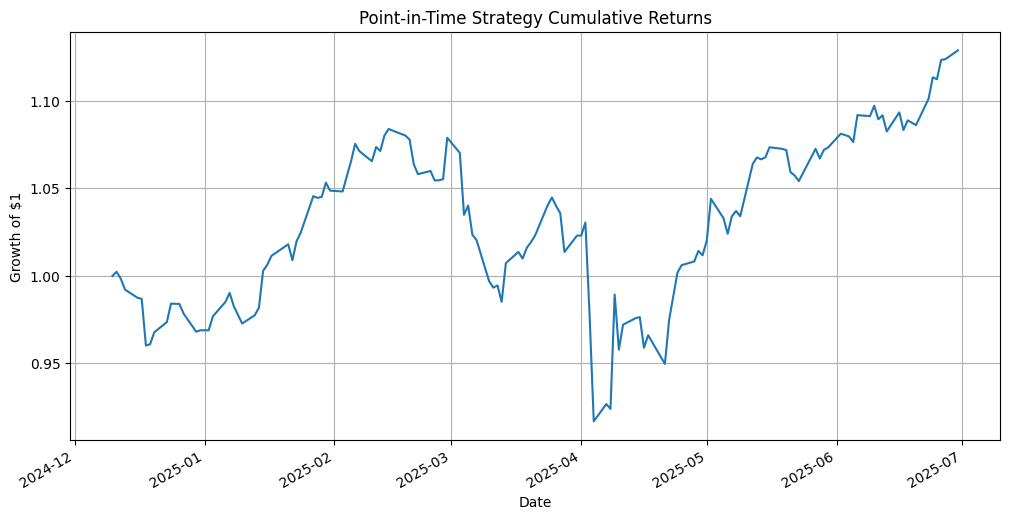


Total Return (Test): 12.88%
Annualized Return (Test): 24.97%
Annualized Volatility (Test): 21.73%
Sharpe Ratio (Test): 1.15


In [19]:
# Initialize last_selected_tickers before the loop
last_selected_tickers = []

for i, rebalance_date in enumerate(rebalance_dates):
    if last_rebalance_date is not None:
        # Define the holding period for the previously selected portfolio
        # From the last rebalance date up to the day before the current one
        holding_period_mask = (price_data_close.index >= last_rebalance_date) & (price_data_close.index < rebalance_date)
        holding_period_prices = price_data_close[holding_period_mask]

        if not holding_period_prices.empty and last_selected_tickers:
            # Calculate returns for the selected tickers during this holding period
            # Ensure we only calculate returns for tickers that were actually in the last selected list
            period_returns = holding_period_prices[last_selected_tickers].pct_change().fillna(0)
            # Assume equal weight for the period
            equal_weight_returns = period_returns.mean(axis=1)
            all_period_returns.append(equal_weight_returns)

    # --- Point-in-Time Analysis for the current rebalance_date ---
    # Use only data available up to this point to decide the new portfolio
    print(f"\nRebalancing for period starting {rebalance_date.date()}...")
    # Ensure point_in_time_data includes the rebalance_date for factor calculation
    point_in_time_data = price_data_close[price_data_close.index <= rebalance_date]

    if point_in_time_data.empty:
        print("  -> Skipping: Not enough historical data to calculate factors.")
        last_selected_tickers = [] # Reset tickers
        last_rebalance_date = rebalance_date
        continue

    # Fix: Access the first and last index values, not columns
    print(f"Analysing point in time data from {point_in_time_data.index[0].date()} to {point_in_time_data.index[-1].date()}")

    # Recalculate factors using only point-in-time data using the refactored classes
    # Instantiate factor objects
    value_factor = Value()
    momentum_factor = Momentum()
    factors_to_calculate = [value_factor, momentum_factor]

    # Use the calculate_factors static method from the Factor class
    # Pass the relevant tickers for factor calculation (e.g., the initial subset or all S&P500)
    # Assuming 'tickers' is the list of tickers you are considering for selection
    factor_df = Factor.calculate_factors(point_in_time_data, tickers, factors_to_calculate)

    if factor_df.empty:
        print("  -> Skipping: No valid tickers after factor calculation.")
        last_selected_tickers = []
        last_rebalance_date = rebalance_date
        continue

    # Perform Composite Scoring and Select Top N stocks based on the point-in-time factor_df
    # Rank: lower P/E is better, higher momentum is better
    # Ensure 'pe_ratio' and '6m_return' columns exist before ranking
    if 'pe_ratio' in factor_df.columns and '6m_return' in factor_df.columns:
        factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending=True, na_option='bottom')
        factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False, na_option='bottom')
        # Simple equal-weight composite score
        factor_df['composite_score'] = (factor_df['pe_rank'].fillna(factor_df.shape[0]+1) + factor_df['mom_rank'].fillna(factor_df.shape[0]+1)) / 2 # Handle NaNs in ranking

        # Select top N stocks using the refined factor_df
        # Ensure there are enough stocks to select TOP_N_STOCKS
        if not factor_df.empty and factor_df.shape[0] >= TOP_N_STOCKS:
             selected = factor_df.nsmallest(TOP_N_STOCKS, 'composite_score')
             last_selected_tickers = selected.index.tolist()
             print(f"  -> New portfolio: {last_selected_tickers}")
        elif not factor_df.empty:
             # If fewer than TOP_N_STOCKS are available, select all available
             last_selected_tickers = factor_df.nsmallest(factor_df.shape[0], 'composite_score').index.tolist()
             print(f"  -> Selected {len(last_selected_tickers)} stocks (fewer than TOP_N_STOCKS): {last_selected_tickers}")
        else:
            print("  -> Skipping: No stocks available for selection after scoring.")
            last_selected_tickers = []
    else:
        print("  -> Skipping: Required factor columns ('pe_ratio', '6m_return') not found in factor_df for scoring.")
        last_selected_tickers = []


    last_rebalance_date = rebalance_date


# 4. Concatenate all period returns into a single time series
if all_period_returns:
    portfolio_returns = pd.concat(all_period_returns)

    # 5. Calculate final cumulative returns and performance stats
    # Correct calculation of cumulative returns: (1 + daily_returns).cumprod()
    cum_returns = (1 + portfolio_returns).cumprod()

    print("\n--- Backtest Complete ---")
    # Displaying the final cumulative return plot
    plt.figure(figsize=(12, 6))
    cum_returns.plot()
    plt.title('Point-in-Time Strategy Cumulative Returns')
    plt.ylabel('Growth of $1')
    plt.grid()
    plt.show()

    # Displaying the performance stats
    total_return = cum_returns.iloc[-1] - 1
    # Ensure we have enough data points for annualized calculations
    if len(cum_returns) > 1:
        duration_years = len(cum_returns) / 252.0 # Assuming 252 trading days in a year
        annualized_return = (1 + total_return)**(1/duration_years) - 1 if duration_years > 0 else total_return
        annualized_vol = portfolio_returns.std() * np.sqrt(252)
        sharpe = annualized_return / annualized_vol if annualized_vol != 0 else 0

        print(f"\nTotal Return (Test): {total_return:.2%}")
        print(f"Annualized Return (Test): {annualized_return:.2%}")
        print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
        print(f"Sharpe Ratio (Test): {sharpe:.2f}")
    else:
        print("\nNot enough data points to calculate annualized metrics.")
        print(f"\nTotal Return (Test): {total_return:.2%}")


else:
    print("\nBacktest could not be completed. No returns were generated.")
    # Initialize empty series to avoid errors if no returns were generated
    portfolio_returns = pd.Series(index=test_dates if 'test_dates' in locals() else None)
    cum_returns = pd.Series(index=test_dates if 'test_dates' in locals() else None)


--- Backtest Complete ---


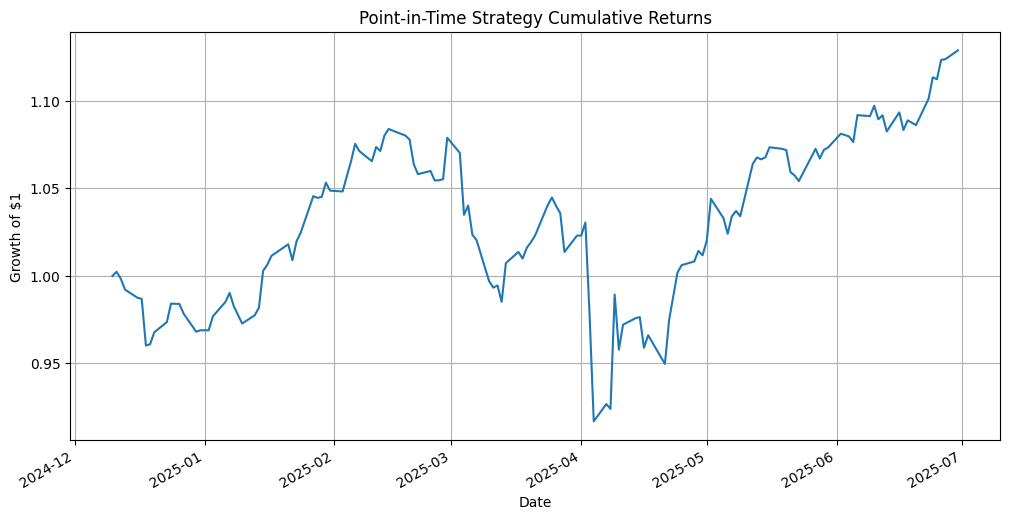


Total Return (Test): 12.88%
Annualized Return (Test): 24.97%
Annualized Volatility (Test): 21.73%
Sharpe Ratio (Test): 1.15


In [20]:
# 4. Concatenate all period returns into a single time series
if all_period_returns:
    portfolio_returns = pd.concat(all_period_returns)

    # 5. Calculate final cumulative returns and performance stats
    cum_returns = (1 + portfolio_returns).cumprod()

    print("\n--- Backtest Complete ---")
    # Displaying the final cumulative return plot
    plt.figure(figsize=(12, 6))
    cum_returns.plot()
    plt.title('Point-in-Time Strategy Cumulative Returns')
    plt.ylabel('Growth of $1')
    plt.grid()
    plt.show()

    # Displaying the performance stats
    total_return = cum_returns.iloc[-1] - 1
    annualized_return = cum_returns.iloc[-1]**(252/len(cum_returns)) - 1
    annualized_vol = portfolio_returns.std() * np.sqrt(252)
    sharpe = annualized_return / annualized_vol if annualized_vol != 0 else 0

    print(f"\nTotal Return (Test): {total_return:.2%}")
    print(f"Annualized Return (Test): {annualized_return:.2%}")
    print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
    print(f"Sharpe Ratio (Test): {sharpe:.2f}")

else:
    print("\nBacktest could not be completed. No returns were generated.")
    # Initialize empty series to avoid errors if no returns were generated
    portfolio_returns = pd.Series()
    cum_returns = pd.Series()

In [21]:
# =======================
# 8a. Results Visualization
# =======================
# Plot daily returns for each selected stock
# for ticker in selected_tickers:
#     plt.figure(figsize=(12, 6))
#     returns[ticker].plot()
#     plt.title(f'Daily Returns for {ticker} (Test Set)')
#     plt.ylabel('Daily Return')
#     plt.xlabel('Date')
#     plt.grid()
#     plt.show()

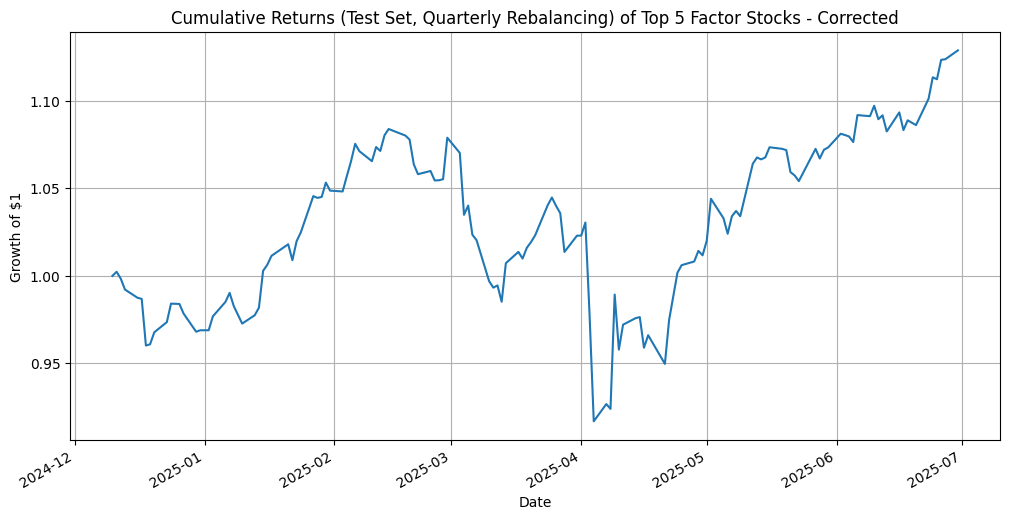

In [22]:
# =======================
# 8b. cum_returns, Full Portfolio Results Visualization
# =======================
plt.figure(figsize=(12,6))
cum_returns.plot() # Use the corrected cum_returns
plt.title('Cumulative Returns (Test Set, Quarterly Rebalancing) of Top 5 Factor Stocks - Corrected') # Update title
plt.ylabel('Growth of $1')
plt.xlabel('Date')
plt.grid()
plt.show()

In [23]:
# =======================
# 9. Simple Performance Stats
# =======================
total_return = cum_returns.iloc[-1] - 1
annualized_return = cum_returns.iloc[-1]**(252/len(cum_returns)) - 1
annualized_vol = portfolio_returns.std() * np.sqrt(252)
sharpe = annualized_return / annualized_vol

print(f"Last value of cumulative returns: {cum_returns.iloc[-1]:.2f}")
print(f"Total Return (Test): {total_return:.2%}")
print(f"Annualized Return (Test): {annualized_return:.2%}")
print(f"Annualized Volatility (Test): {annualized_vol:.2%}")
print(f"Sharpe Ratio (Test): {sharpe:.2f}")

Last value of cumulative returns: 1.13
Total Return (Test): 12.88%
Annualized Return (Test): 24.97%
Annualized Volatility (Test): 21.73%
Sharpe Ratio (Test): 1.15


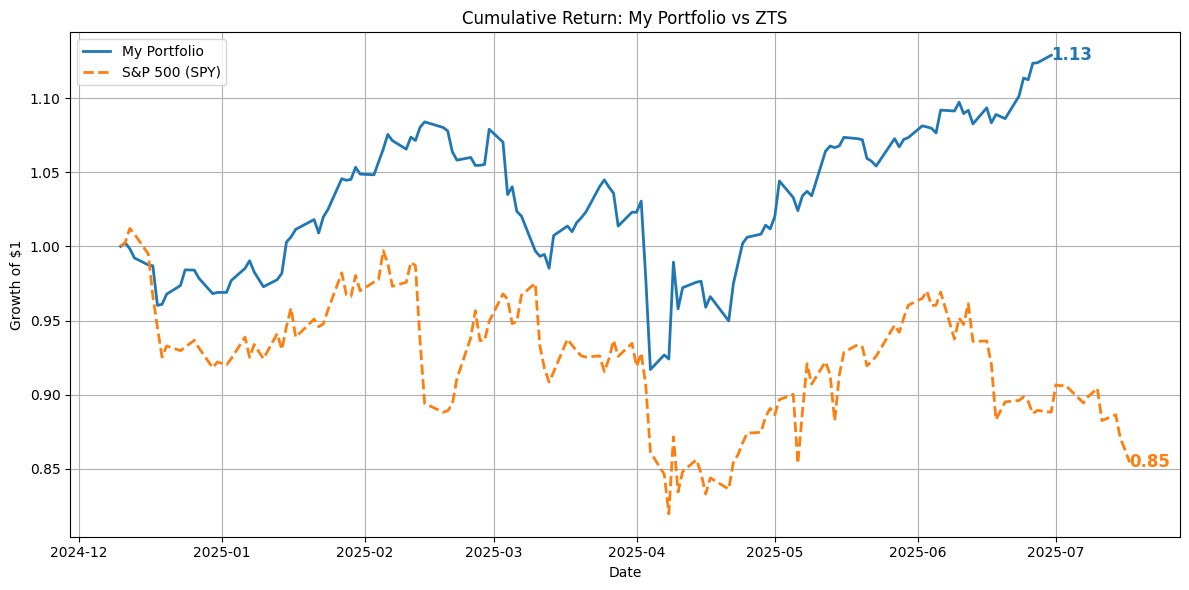

In [24]:
# =======================
# 8. Results Visualization (with Benchmark)
# =======================

# 1. Download benchmark data for the test period
ticker_data = yf.download(ticker, start=test_dates[0], end=test_dates[-1], auto_adjust=True, progress=False)
ticker_close_prices = ticker_data['Close']

# 2. Calculate SPY's daily returns and cumulative returns
benchmark_returns = ticker_close_prices.pct_change().fillna(0)
benchmark_cum_returns = (1 + benchmark_returns).cumprod()

# Align the two time series to a common index
common_index = cum_returns.index.union(benchmark_cum_returns.index)
cum_returns_aligned = cum_returns.reindex(common_index)
benchmark_cum_returns_aligned = benchmark_cum_returns.reindex(common_index)


# 3. Plot both on the same graph
plt.figure(figsize=(12, 6))

# Plot your portfolio
plt.plot(cum_returns_aligned.index, cum_returns_aligned.values,
         label='My Portfolio', linewidth=2)

# Plot the benchmark
plt.plot(benchmark_cum_returns_aligned.index, benchmark_cum_returns_aligned.values,
         linestyle='--', label='S&P 500 (SPY)', linewidth=2)

# Annotate final values
last_portfolio_date = cum_returns_aligned.dropna().index[-1]
last_portfolio_value = cum_returns_aligned.dropna().iloc[-1]

last_benchmark_date = benchmark_cum_returns_aligned.dropna().index[-1]
last_benchmark_value = benchmark_cum_returns_aligned.dropna().iloc[-1].iloc[0] # Access the scalar value


plt.text(last_portfolio_date, last_portfolio_value,
         f"{last_portfolio_value:.2f}",
         color='C0', fontsize=12, va='center', ha='left', fontweight='bold')

plt.text(last_benchmark_date, last_benchmark_value,
         f"{last_benchmark_value:.2f}",
         color='C1', fontsize=12, va='center', ha='left', fontweight='bold')

plt.title(f'Cumulative Return: My Portfolio vs {ticker}') # Update title
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Saves entire file to app.py

In [25]:
%%writefile app.py
# This entire cell will be saved as app.py


import streamlit as st
import plotly.express as px
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yfinance as yf
import time # Import time for simulating progress
import os # Import os for checking file existence

# Define functions (copied from the Colab notebook)

def download_sp500_tickers(debug=False, storage_path='sp500_tickers.parquet'):
    """
    Fetches S&P 500 tickers and market caps and returns a sorted DataFrame.
    If debug is True, attempts to load from storage_path first.
    If loading fails or debug is False, downloads from Wikipedia and saves to storage_path.
    """
    if debug and os.path.exists(storage_path):
        try:
            st.info(f"Attempting to load S&P 500 tickers from {storage_path}...")
            market_caps_df = pd.read_parquet(storage_path)
            st.success(f"Successfully loaded S&P 500 tickers from {storage_path}.")
            return market_caps_df
        except Exception as e:
            st.warning(f"Could not load S%26P 500 tickers from {storage_path}: {e}. Downloading instead.")

    # If not in debug mode or loading failed, download from Wikipedia
    try:
        sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
        sp500_table = pd.read_html(sp500_url)
        sp500 = sp500_table[0]
        tickers = sp500['Symbol'].tolist()
        market_caps = []
        total_tickers = len(tickers)
        progress_bar = st.progress(0)
        status_text = st.empty()

        st.info("Downloading S&P 500 data from Wikipedia...")
        for i, ticker in enumerate(tickers):
            try:
                info = yf.Ticker(ticker).info
                cap = info.get('marketCap', None)
                if cap is not None:
                    market_caps.append((ticker, cap))
            except Exception:
                continue
            # Update progress bar and status text
            progress = (i + 1) / total_tickers
            progress_bar.progress(progress)
            status_text.text(f"Downloading S&P 500 data: {i+1}/{total_tickers} tickers processed...")

        progress_bar.empty()
        status_text.empty()

        market_caps_df = pd.DataFrame(market_caps, columns=['Ticker', 'MarketCap'])
        market_caps_df = market_caps_df.sort_values(by='MarketCap', ascending=False).reset_index(drop=True)

        # Save the downloaded data to Parquet
        try:
            market_caps_df.to_parquet(storage_path)
            st.success(f"Saved S&P 500 tickers to {storage_path}.")
        except Exception as e:
            st.warning(f"Could not save S%26P 500 tickers to {storage_path}: {e}")

        return market_caps_df
    except Exception as e:
        st.error(f"Error downloading S%26P 500 tickers from Wikipedia: {e}")
        return pd.DataFrame(columns=['Ticker', 'MarketCap'])


def download_price_data(tickers, start_date, end_date):
    """Downloads historical price data for a list of tickers."""
    try:
        st.info(f"Downloading price data for {len(tickers)} tickers...")
        price_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True, progress=False)
        # yf.download returns a DataFrame with a MultiIndex on columns if multiple tickers are downloaded.
        # The levels are ('Ticker', 'Price_Info').
        # If only one ticker is downloaded, it returns a DataFrame with a single level index ('Price_Info').
        st.success("Price data downloaded.")
        return price_data
    except Exception as e:
        st.error(f"Error downloading price data: {e}")
        return pd.DataFrame()


def calculate_factors(price_data_close, tickers):
    """Calculates Value (P/E) and Momentum (6-month return) factors."""
    st.info("Calculating factors...")
    factor_df = pd.DataFrame(index=tickers)
    total_tickers = len(tickers)
    progress_bar = st.progress(0)
    status_text = st.empty()

    # st.text(f"Calculating factors for {total_tickers} tickers...") # Added logging
    # st.text("Initial factor_df columns: pe_ratio, 6m_return") # Added logging


    for i, ticker in enumerate(tickers):
        try:
            info = yf.Ticker(ticker).info
            # Explicitly check if 'trailingPE' is None and assign np.nan if it is
            pe_ratio = info.get('trailingPE')
            factor_df.loc[ticker, 'pe_ratio'] = pe_ratio if pe_ratio is not None else np.nan
        except Exception as e: # Added exception logging
            factor_df.loc[ticker, 'pe_ratio'] = np.nan
            # st.text(f"Error getting PE for {ticker}: {e}") # Added logging


        try:
            # Use the simplified price_data_close DataFrame (single-level columns: Ticker)
            if ticker in price_data_close.columns:
                # Explicitly filter out NaNs instead of using dropna()
                prices = price_data_close[ticker][~price_data_close[ticker].isna()]
                if len(prices) > 126:
                    factor_df.loc[ticker, '6m_return'] = (prices.iloc[-1] / prices.iloc[-126]) - 1
                else:
                    factor_df.loc[ticker, '6m_return'] = np.nan
                    # st.text(f"Insufficient data for 6m return for {ticker}: {len(prices)} data points") # Added logging
            else:
                factor_df.loc[ticker, '6m_return'] = np.nan
                # st.text(f"Ticker {ticker} not in price_data_close columns.") # Added logging


        except Exception as e: # Added exception logging
            factor_df.loc[ticker, '6m_return'] = np.nan
            # st.text(f"Error calculating 6m return for {ticker}: {e}") # Added logging


        # Update progress bar and status text
        progress = (i + 1) / total_tickers
        progress_bar.progress(progress)
        status_text.text(f"Calculating factors: {i+1}/{total_tickers} tickers processed...")


    progress_bar.empty()
    status_text.empty()

    # st.text("Factor calculation loop finished.") # Added logging
    # st.text(f"Factor_df before dropna():\n{factor_df}") # Added logging

    factor_df = factor_df.dropna() # Keep dropna here for rows with missing factors

    # st.text(f"Factor_df after dropna():\n{factor_df}") # Added logging


    if not factor_df.empty:
        factor_df['pe_rank'] = factor_df['pe_ratio'].rank(ascending=True)
        factor_df['mom_rank'] = factor_df['6m_return'].rank(ascending=False)
        factor_df['composite_score'] = (factor_df['pe_rank'] + factor_df['mom_rank']) / 2
        st.success(f"Factors calculated for {len(factor_df)} tickers.") # Updated success message
    else:
        st.warning("No tickers with complete factor data found.") # Added specific warning
    return factor_df

def select_top_n_stocks(factor_df, top_n):
    """Selects the top N stocks based on the composite score."""
    st.info(f"Selecting top {top_n} stocks...")
    if not factor_df.empty:
        selected = factor_df.nsmallest(top_n, 'composite_score')
        selected_tickers = selected.index.tolist()
        st.success(f"Selected stocks: {selected_tickers}")
        return selected_tickers
    st.warning("No stocks selected because factor_df is empty.") # Updated warning
    return []


def run_backtest(price_data_close, selected_tickers, split_ratio, rebalance_freq='QS'):
    """Runs a quarterly rebalancing backtest on selected stocks."""
    st.info("Running backtest...")
    if not selected_tickers or price_data_close.empty:
        st.warning("Backtest skipped due to missing data or selected tickers.")
        return pd.Series(), pd.Series()

    try:
        # Filter price data for selected tickers and test period (already close prices)
        all_dates = price_data_close.index
        split_idx = int(len(all_dates) * split_ratio)
        test_dates = all_dates[split_idx:]

        if test_dates.empty:
             st.warning("Test period is empty. Adjust split ratio or data years.")
             return pd.Series(index=all_dates), pd.Series(index=all_dates)


        # Ensure selected_tickers columns exist in price_data_close
        valid_selected_tickers = [t for t in selected_tickers if t in price_data_close.columns]

        if not valid_selected_tickers:
             st.warning("None of the selected tickers have price data available in the test period.")
             return pd.Series(index=test_dates), pd.Series(index=test_dates)

        selected_prices_test_close = price_data_close.loc[test_dates, valid_selected_tickers]


        all_test_dates = selected_prices_test_close.index
        rebalance_targets = pd.date_range(start=all_test_dates[0], end=all_test_dates[-1], freq=rebalance_freq)

        mapped_rebalance_dates = []
        for target in rebalance_targets:
            candidates = all_test_dates[all_test_dates >= target]
            if not candidates.empty:
                mapped_rebalance_dates.append(candidates[0])
        if all_test_dates[0] not in mapped_rebalance_dates:
            mapped_rebalance_dates = [all_test_dates[0]] + mapped_rebalance_dates

        # Initialize portfolio weights equally
        # Ensure weights DataFrame has the same columns as selected_prices_test_close
        portfolio = pd.DataFrame(1 / len(valid_selected_tickers), index=all_test_dates, columns=valid_selected_tickers)


        # Calculate daily returns using the close prices only
        returns = selected_prices_test_close.pct_change().fillna(0)

        # Calculate portfolio returns by applying weights to daily returns and summing across tickers
        # Multiplication should now work as both DataFrames have the same single-level columns (Tickers)
        portfolio_returns = (returns * portfolio).sum(axis=1)

        # Calculate cumulative returns
        cum_returns = (1 + portfolio_returns).cumprod()

        st.success("Backtest completed.")
        return cum_returns, portfolio_returns
    except Exception as e:
        st.error(f"Error during backtest: {e}")
        # Return empty series with the correct index if possible to avoid downstream errors
        if 'test_dates' in locals():
             return pd.Series(index=test_dates), pd.Series(index=test_dates)
        else:
             return pd.Series(), pd.Series()


# Set the title of the Streamlit application
st.title('Stock Backtesting Strategy')

# Create a section for parameter inputs
st.header('Backtesting Parameters')
with st.expander("Adjust Parameters"):
    st.write("Configure the parameters for the backtesting simulation.")

    # Add DEBUG checkbox
    debug_mode = st.checkbox('Debug Mode (Load S&P 500 tickers from storage)')


    # Input widget for SPLIT_RATIO
    split_ratio = st.number_input(
        'Train/Test Split Ratio',
        min_value=0.1,
        max_value=0.9,
        value=0.7,
        step=0.05,
        help="Ratio of data to use for training (e.g., 0.7 for 70% train, 30% test)"
    )

    # Input widget for DATA_YEARS
    data_years = st.number_input(
        'Number of Years of Data',
        min_value=1,
        max_value=10,
        value=2,
        step=1,
        help="Number of years of historical data to download"
    )

    # Input widget for TOP_N_STOCKS
    top_n_stocks = st.number_input(
        'Top N Stocks to Select',
        min_value=1,
        max_value=50,
        value=5,
        step=1,
        help="Number of top-ranked stocks to include in the portfolio"
    )

# Define the main logic to run when parameters change
if st.button('Run Backtest'):
    # Get the current date
    end_date = datetime.today()
    # Calculate the start date based on DATA_YEARS
    start_date = end_date - timedelta(days=365 * data_years)

    # --- Backtesting Logic ---
    # Download S&P 500 tickers (using a subset for faster demo)
    with st.spinner("Downloading S&P 500 tickers..."):
        # Pass the debug_mode value to the function
        market_caps_df = download_sp500_tickers(debug=debug_mode)
    if market_caps_df.empty:
        st.stop()

    all_tickers = market_caps_df['Ticker'].tolist()
    # Use a smaller subset for faster demo
    subset_tickers = all_tickers[:50] # Adjust subset size as needed

    # Download price data for the subset
    price_data = download_price_data(subset_tickers, start_date, end_date)
    if price_data.empty:
        st.stop()

    # Explicitly extract only 'Close' prices and create a new DataFrame with simple columns
    if isinstance(price_data.columns, pd.MultiIndex):
         # Select 'Close' for all tickers in subset_tickers
         price_data_close = price_data.loc[:, (subset_tickers, 'Close')]
         # Drop the 'Price' level to have tickers as single-level columns
         price_data_close.columns = price_data_close.columns.droplevel('Price')
    else: # Handle case where price_data might not have a MultiIndex (e.g., single ticker download)
         # Assuming it's already the close series for a single ticker, convert to DataFrame
         price_data_close = pd.DataFrame(price_data)
         price_data_close.columns = [subset_tickers[0]] # Set the ticker as the column name


    # Calculate factors and select top N stocks using the simplified price_data_close
    factor_df = calculate_factors(price_data_close, subset_tickers)
    if factor_df.empty:
        st.warning("Could not calculate factors for any tickers. Please adjust parameters (e.g., increase data years or reduce the number of top stocks).") # More informative warning
        st.stop()

    selected_tickers = select_top_n_stocks(factor_df, top_n_stocks)

    if not selected_tickers:
        st.warning("No stocks selected based on the criteria after factor calculation. Please adjust parameters.")
    else:
        # st.write(f"Selected stocks for backtest: {selected_tickers}") # Moved inside select_top_n_stocks

        # Run the backtest using the simplified price_data_close
        cum_returns, portfolio_returns = run_backtest(price_data_close, selected_tickers, split_ratio)

        if cum_returns.empty:
             st.warning("Backtest did not produce cumulative returns. Check data availability and parameters.")
             st.stop()


        # Download SPY data for benchmark
        spy_ticker = '^GSPC'
        try:
            with st.spinner("Downloading benchmark data..."):
                # Download benchmark data for the specific test period
                # Ensure benchmark data aligns with the portfolio's test period index
                benchmark_data = yf.download(spy_ticker, start=cum_returns.index[0], end=cum_returns.index[-1], auto_adjust=True, progress=False)
            benchmark_cum_returns = (1 + benchmark_data['Close'].pct_change().fillna(0)).cumprod()
            benchmark_returns = benchmark_data['Close'].pct_change().fillna(0)


             # Align the two time series to a common index, forward filling missing values
            common_index = cum_returns.index.union(benchmark_cum_returns.index)
            cum_returns_aligned = cum_returns.reindex(common_index).fillna(method='ffill')
            benchmark_cum_returns_aligned = benchmark_cum_returns.reindex(common_index).fillna(method='ffill')

        except Exception as e:
             st.warning(f"Could not download benchmark data or align: {e}. Skipping benchmark.")
             cum_returns_aligned = cum_returns.reindex(cum_returns.index) # Ensure it's a Series even if benchmark fails
             benchmark_cum_returns_aligned = pd.Series(index=cum_returns.index) # Empty benchmark series with portfolio index
             benchmark_returns = pd.Series(index=cum_returns.index) # Initialize benchmark_returns to empty Series in case of error


        # --- Results Visualization (Interactive Graph) ---
        st.header('Cumulative Returns')
        st.write("Visualize the cumulative returns of the selected portfolio vs. a benchmark.")

        if not cum_returns_aligned.empty:
            # Create a DataFrame for plotting
            plot_df = pd.DataFrame({
                'Date': cum_returns_aligned.index,
                'My Portfolio': cum_returns_aligned.values
            })

            if not benchmark_cum_returns_aligned.empty:
                 # Only add benchmark if it's not an empty series
                 plot_df['S&P 500'] = benchmark_cum_returns_aligned.values

            # Reshape the DataFrame for Plotly
            plot_df_melted = plot_df.melt(
                'Date',
                var_name='Strategy',
                value_name='Cumulative Returns'
            )

            # Create the interactive Plotly line chart
            fig = px.line(
                plot_df_melted,
                x='Date',
                y='Cumulative Returns',
                color='Strategy',
                title='Cumulative Return: My Portfolio vs S&P 500'
            )

            # Display the Plotly figure in Streamlit
            st.plotly_chart(fig, use_container_width=True)
        else:
            st.warning("No cumulative returns data to plot.")

        # --- Performance Metrics ---
        st.header('Performance Metrics')
        st.write("Key performance indicators for the backtested strategy.")

        # Ensure we have enough data to calculate metrics
        if not portfolio_returns.empty and len(cum_returns) > 1:
            # --- Create Columns for Display ---
            col1, col2 = st.columns(2)

            # --- Portfolio Calculations ---
            with col1:
                st.subheader("My Portfolio")
                try:
                    total_return = cum_returns.iloc[-1] - 1
                    duration_years = len(cum_returns) / 252.0
                    annualized_return = (1 + total_return)**(1/duration_years) - 1
                    annualized_vol = portfolio_returns.std() * np.sqrt(252)

                    # Safely calculate Sharpe Ratio
                    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0.0

                    st.metric(label="Total Return", value=f"{total_return:.2%}")
                    st.metric(label="Annualized Return", value=f"{annualized_return:.2%}")
                    st.metric(label="Annualized Volatility", value=f"{annualized_vol:.2%}")
                    st.metric(label="Sharpe Ratio", value=f"{sharpe_ratio:.2f}")
                except Exception as e:
                    st.error(f"Error calculating portfolio metrics: {e}")


            # --- Benchmark Calculations ---
            with col2:
                st.subheader("S&P 500 (Benchmark)")
                # Check if benchmark data is valid before trying to calculate
                if not benchmark_returns.empty and not benchmark_returns.isnull().values.all() and len(benchmark_cum_returns) > 1:
                    try:
                        # Use .item() to ensure we have a single Python number
                        bench_total_return = (benchmark_cum_returns.iloc[-1] - 1).item()
                        bench_duration_years = len(benchmark_cum_returns) / 252.0
                        bench_annualized_return = (1 + bench_total_return)**(1/bench_duration_years) - 1
                        bench_annualized_vol = (benchmark_returns.std() * np.sqrt(252)).item()

                        # Safely calculate Sharpe Ratio for the benchmark
                        bench_sharpe_ratio = bench_annualized_return / bench_annualized_vol if bench_annualized_vol > 0 else 0.0

                        st.metric(label="Total Return", value=f"{bench_total_return:.2%}")
                        st.metric(label="Annualized Return", value=f"{bench_annualized_return:.2%}")
                        st.metric(label="Annualized Volatility", value=f"{bench_annualized_vol:.2%}")
                        st.metric(label="Sharpe Ratio", value=f"{bench_sharpe_ratio:.2f}")
                    except Exception as e:
                        st.error(f"Error calculating benchmark metrics: {e}")
                else:
                    st.warning("Not enough benchmark data to calculate metrics.")
        else:
            st.warning("No performance metrics to display. Insufficient data.")

Writing app.py


## Run streamlit app

### Subtask:
Start the Streamlit application using `streamlit run app.py`.


**Reasoning**:
The Streamlit application code has been written to `app.py`. The next step is to start the Streamlit server to run the application.



In [26]:
# This script will kill the old processes and start a new one.
from pyngrok import ngrok
from google.colab import userdata

# Step 1: Kill any running Streamlit process
# This is the crucial step you were missing.
print("Attempting to kill previous Streamlit process...")
!kill $(ps -ef | grep "streamlit" | grep -v "grep" | awk '{print $2}')
print("Kill command sent.")

# Step 2: Disconnect all ngrok tunnels and kill the ngrok process
print("\nDisconnecting all ngrok tunnels...")
ngrok.kill()

# Step 3: Relaunch everything
print("Setting up new ngrok tunnel...")
ngrok_token = userdata.get('NGROK_API_KEY')
if ngrok_token:
    ngrok.set_auth_token(ngrok_token)
else:
    print("WARNING: NGROK_API_KEY not found in Colab Secrets.")

# Open the tunnel
public_url = ngrok.connect(8501)
print(f"New Public URL: {public_url}")

# Run the updated app.py in the background
print("Starting new Streamlit app...")
!streamlit run app.py &>/dev/null&
print("App is running in the background. Please use the new public URL.")

Attempting to kill previous Streamlit process...
kill: usage: kill [-s sigspec | -n signum | -sigspec] pid | jobspec ... or kill -l [sigspec]
Kill command sent.

Disconnecting all ngrok tunnels...
Setting up new ngrok tunnel...
New Public URL: NgrokTunnel: "https://3720ba146bc7.ngrok-free.app" -> "http://localhost:8501"
Starting new Streamlit app...
App is running in the background. Please use the new public URL.
